### Import Required Libraries

In [1]:
# common libraries
import pandas as pd # data manipulation and extraction
import numpy as np # numerical computation
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
import warnings # ignore warnings

# preprocessing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder,label_binarize
from fast_ml.model_development import train_valid_test_split

# classifcation model and model selection libraries
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit 

# model evaluation libraries
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from itertools import cycle

# model inspection libraries
import shap
from scipy.interpolate import interp1d



### Read in the data

In [2]:
data = pd.read_csv('../data/final_predictors.csv')

print(f'Shape of dataframe: {data.shape}')
print('\n')

data.head()

Shape of dataframe: (1321, 20)




,meds_methadone_4,meds_buprenorphine_4,test_Opiate300_4,survey_opiates_4,meds_buprenorphine_2,meds_buprenorphine_3,meds_methadone_2,test_Opiate300_2,test_Opiate300_1,meds_methadone_3,meds_methadone_1,rbs_cocaine,meds_methadone_0,meds_buprenorphine_1,test_Opiate300_3,cows_postdose,rbs_heroine,meds_buprenorphine_0,rbs_amphetamines,dropout
0,0.0,384.0,0.0,0.0,320.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.0,0.0,6.0,30.0,8.0,0.0,0.0
1,0.0,48.0,1.0,5.0,48.0,60.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,48.0,1.0,1.0,30.0,8.0,0.0,0.0
2,360.0,0.0,1.0,9.0,0.0,0.0,310.0,1.0,1.0,420.0,170.0,23.0,30.0,0.0,1.0,5.0,30.0,0.0,0.0,0.0
3,0.0,64.0,1.0,6.0,192.0,160.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,152.0,1.0,9.0,30.0,16.0,0.0,0.0
4,0.0,0.0,1.0,0.0,16.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,16.0,1.0,6.0,4.0,16.0,0.0,1.0


## Remove Features to prevent data leakage
The opiate tests and self reported use for the final month of treatment are removed to prevent data leakage

### Split the data into training, testing and validation sets

In [3]:
# define parameters
train_size = 0.7
valid_size = 0.15
test_size = 0.15

# split data
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = 'dropout', 
                                                                            train_size=train_size, valid_size=valid_size, test_size=test_size)

# print shapes of dataframes
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print('\n')
print(f'Shape of X_valid: {X_valid.shape}')
print(f'Shape of y_valid: {y_valid.shape}')
print('\n')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')


Shape of X_train: (924, 19)
Shape of y_train: (924,)


Shape of X_valid: (198, 19)
Shape of y_valid: (198,)


Shape of X_test: (199, 19)
Shape of y_test: (199,)


In [4]:
 # use label encoder to encode labels for y_train, y_test and y_val
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_valid)

### Fit the model

In [5]:
def fit_model(X_train, y_train):
    parameters = [
        {'n_estimators':[150,200,300], 'learning_rate':[0.1,0.01,0.001]}
    ]

    grid_search = GridSearchCV(XGBClassifier(), 
                               parameters,
                               verbose=True, 
                               scoring='f1', 
                               cv=StratifiedShuffleSplit(n_splits=5),
                               n_jobs=8)
    grid_search.fit(X_train, y_train)
    
    return grid_search

In [6]:
grid_search = fit_model(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [7]:
# print best score and best params from grid search
print(f'Best score: {grid_search.best_score_}')
print('\n')
print(f'Best params: {grid_search.best_params_}')
print('\n')
print(f'Accuracy score for training set: {grid_search.score(X_train, y_train)})')

Best score: 0.7487140327758617


Best params: {'learning_rate': 0.001, 'n_estimators': 150}


Accuracy score for training set: 0.779261586802828)


In [8]:
# refit model with best params
xgb = XGBClassifier(learning_rate=0.1, n_estimators=300)

# fit model
xgb.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=["auc","error"], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

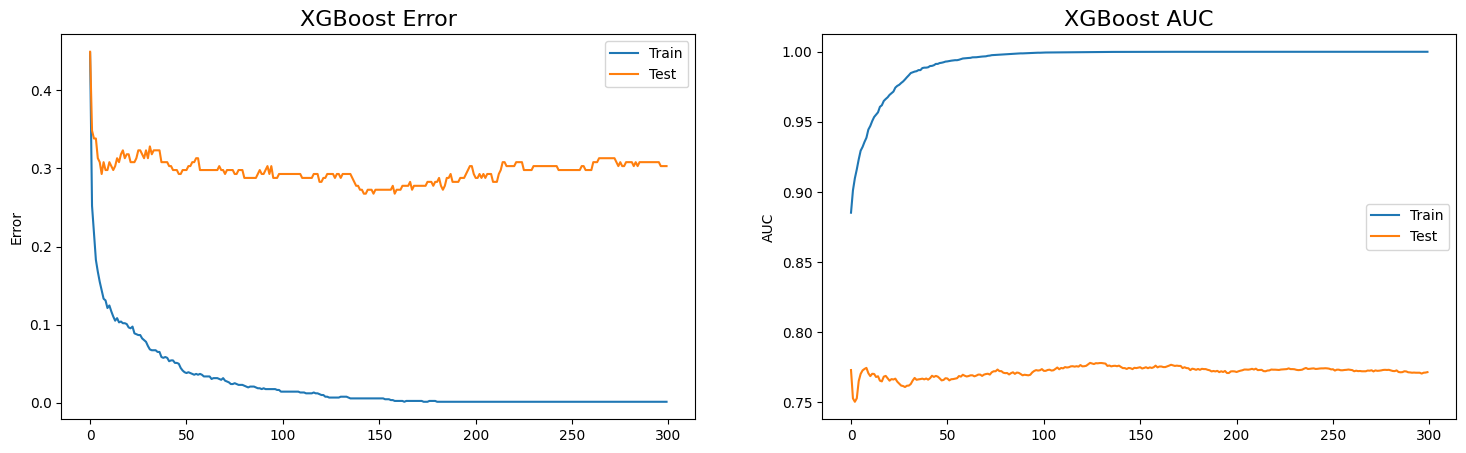

In [9]:
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


### Evaluate the fitted model

In [10]:
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_valid)
y_pred_test = grid_search.predict(X_test)

y_train_prob = xgb.predict_proba(X_train)
y_val_prob = xgb.predict_proba(X_valid)
y_test_prob = xgb.predict_proba(X_test)

In [11]:
# create df for classification report for xtest
report = classification_report(y_test, y_pred_test, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,0.702703,0.285714,0.406250,91.00000
1,0.598765,0.898148,0.718519,108.00000
accuracy,0.618090,0.618090,0.618090,0.61809
macro avg,0.650734,0.591931,0.562384,199.00000
weighted avg,0.646295,0.618090,0.575722,199.00000


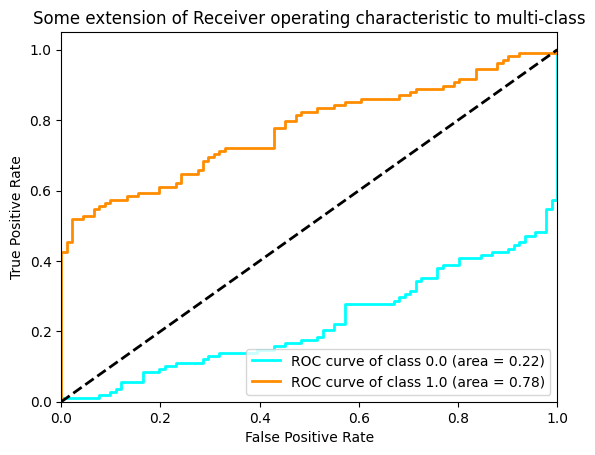

In [12]:
# Plot all ROC curves

#Calculate ROC curve and ROC each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_bin = label_binarize(y_test, classes=[0,1])
n_classes =2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_test_prob[:,i])
    roc_auc[i] = roc_auc_score(y_test, y_test_prob[:,i])
plt.figure()
lw=2
colors = cycle(['aqua', 'darkorange']) #, 'cornflowerblue' ]) #'deeppink','navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

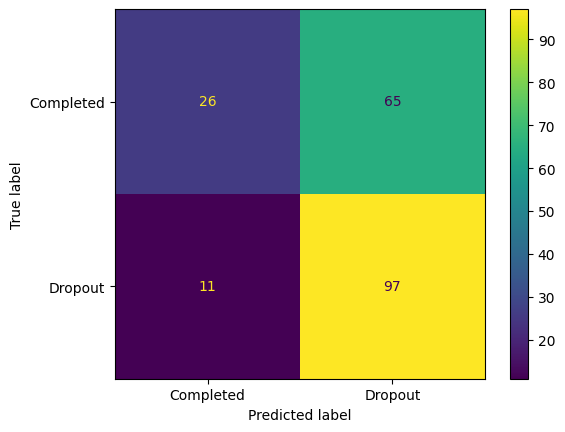

In [13]:
# plot confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Completed', 'Dropout'])
disp.plot();

In [14]:
ex = shap.Explainer(xgb.predict_proba, X_train, max_evals=700)
shap_values = ex(X_test)



PermutationExplainer explainer: 200it [00:17,  5.34it/s]                         


Class index: 1
Data index: 64


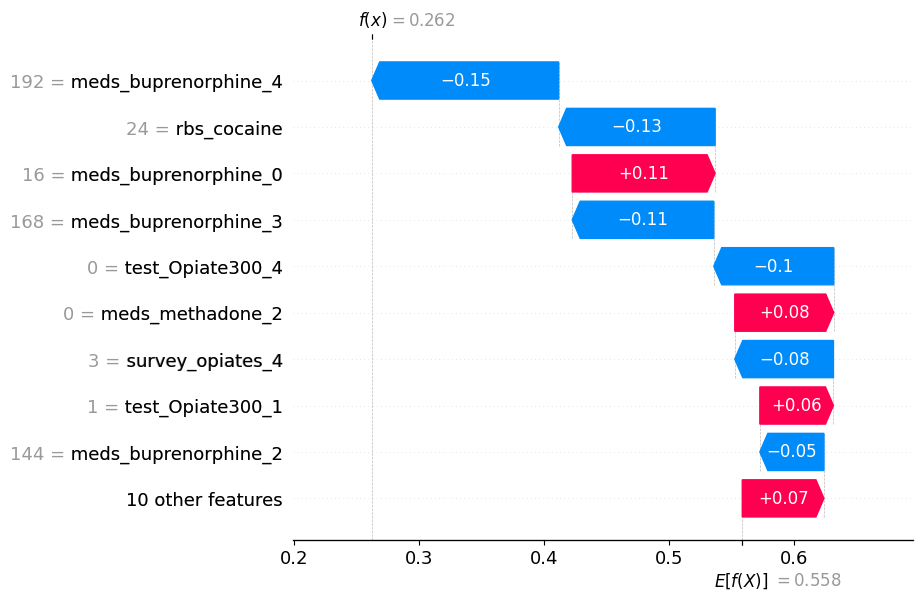

In [15]:
# waterfall plot for clas index 0 
class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.waterfall(shap_values[data_index,:,class_index])

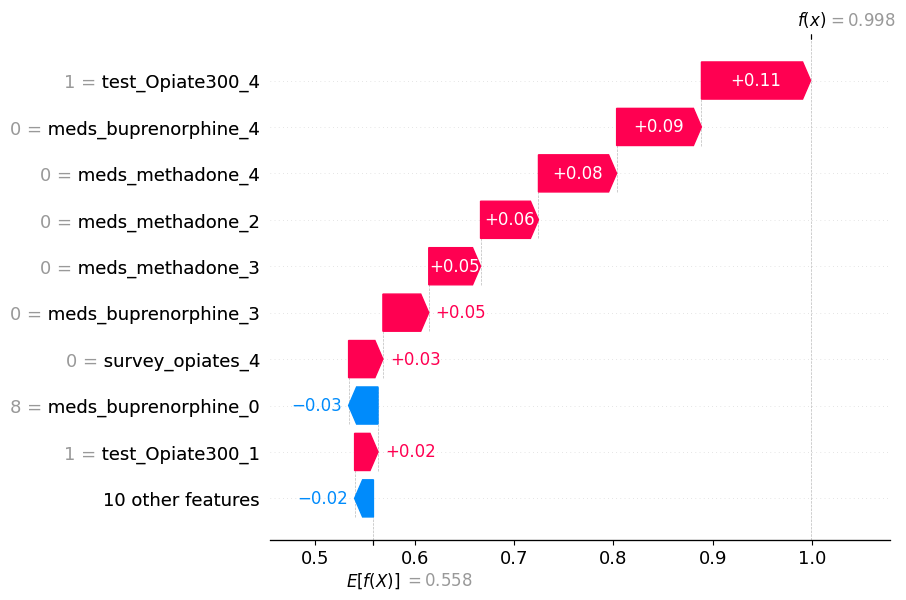

In [16]:
shap.plots.waterfall(shap_values[50,:,1])

Class index: 1
Data index: 124


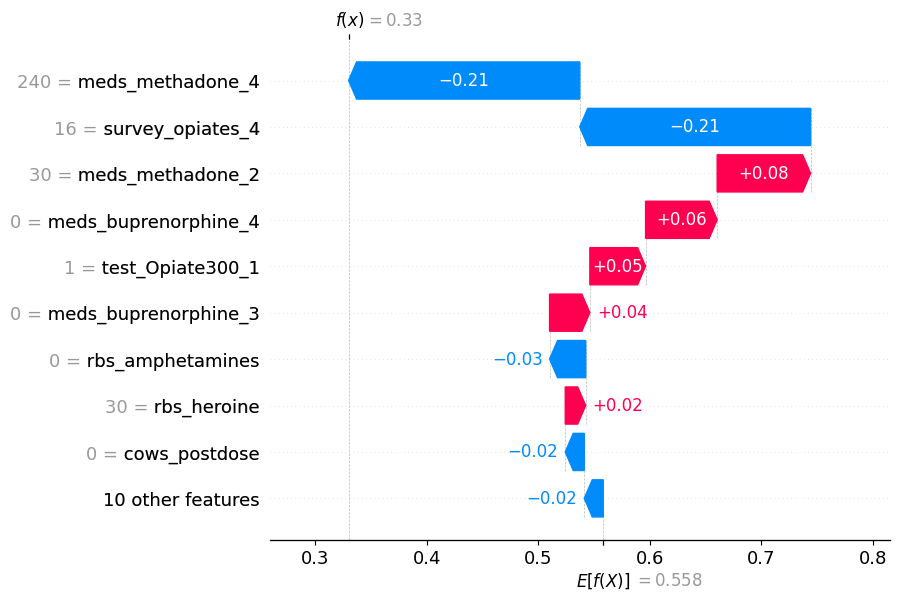

In [17]:
data_index = np.random.choice(shap_values.shape[0])
class_index = 1
print(f'Class index: {class_index}')
print(f'Data index: {data_index}')
shap.plots.waterfall(shap_values[data_index,:,class_index])

Class index: 1
Data index: 129


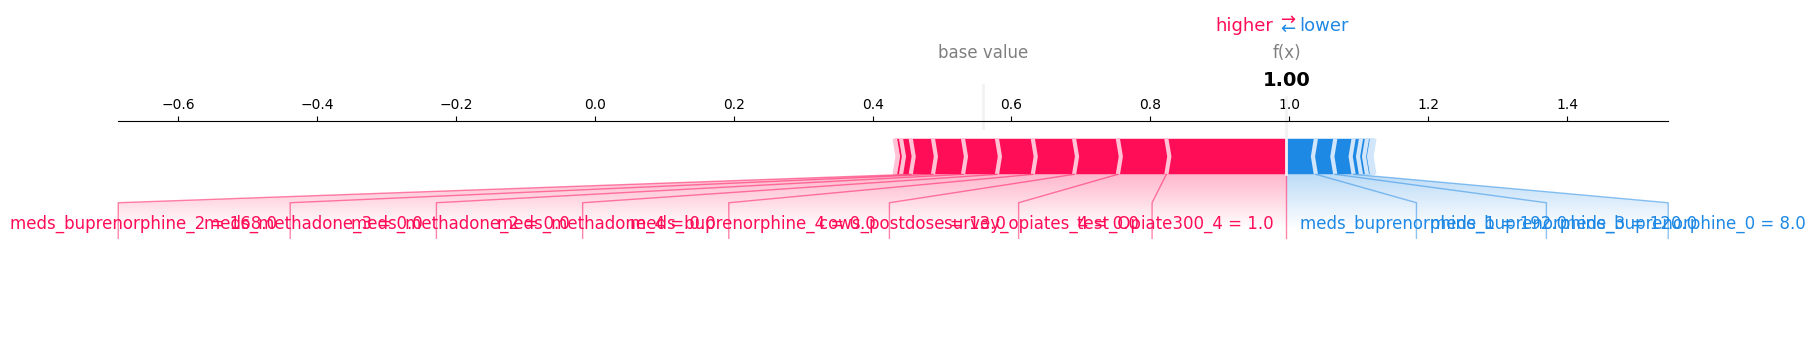

In [18]:
shap.initjs()

class_index = 1
data_index = np.random.choice(shap_values.shape[0])

print(f'Class index: {class_index}')
print(f'Data index: {data_index}')

shap.plots.force(shap_values[data_index,:,class_index], matplotlib=True, show=True)

Class index: 1


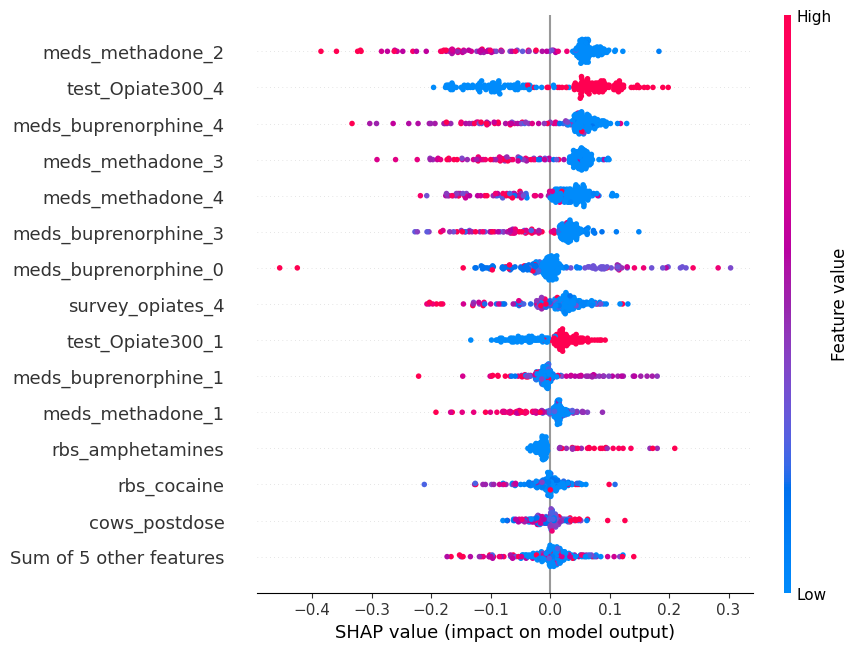

In [19]:
class_index = 1
print(f'Class index: {class_index}')

# shap beeswarm plot
shap.plots.beeswarm(shap_values[:,:,class_index], max_display=15, show=True)

In [23]:
X_test.columns

Index(['meds_methadone_4', 'meds_buprenorphine_4', 'test_Opiate300_4',
       'survey_opiates_4', 'meds_buprenorphine_2', 'meds_buprenorphine_3',
       'meds_methadone_2', 'test_Opiate300_2', 'test_Opiate300_1',
       'meds_methadone_3', 'meds_methadone_1', 'rbs_cocaine',
       'meds_methadone_0', 'meds_buprenorphine_1', 'test_Opiate300_3',
       'cows_postdose', 'rbs_heroine', 'meds_buprenorphine_0',
       'rbs_amphetamines'],
      dtype='object')

In [ ]:
import xgboost as xgb
import shap
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
data = pd.read_csv('../data/final_predictors.csv')
X = data.drop('dropout', axis=1)
y = data['dropout']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=300)
model.fit(X_train, y_train)

# Compute SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Extract SHAP values for the dependence plot
shap_values_array = shap_values.values


In [28]:
X_test.columns

Index(['meds_methadone_4', 'meds_buprenorphine_4', 'test_Opiate300_4',
       'survey_opiates_4', 'meds_buprenorphine_2', 'meds_buprenorphine_3',
       'meds_methadone_2', 'test_Opiate300_2', 'test_Opiate300_1',
       'meds_methadone_3', 'meds_methadone_1', 'rbs_cocaine',
       'meds_methadone_0', 'meds_buprenorphine_1', 'test_Opiate300_3',
       'cows_postdose', 'rbs_heroine', 'meds_buprenorphine_0',
       'rbs_amphetamines'],
      dtype='object')

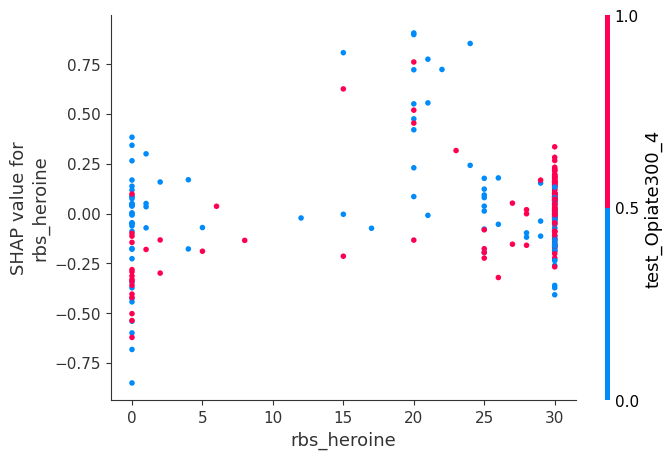

In [32]:

# Create a dependence plot for a specific feature
shap.dependence_plot('rbs_heroine', shap_values_array, X_test, interaction_index='test_Opiate300_4', show=True)